In [1]:
import sys
sys.path.append('/home/shiur/local/large_scale_anomaly/')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import lsa

import os

In [3]:
data_folder = os.path.join(os.path.dirname(lsa.__file__), 'data')

# Load/Visualize/Process special CMB

In [4]:
nside = 64
npix = hp.nside2npix(nside)
fwhm = np.deg2rad(160/60) # 160 arcmin

In [5]:
### load and process
_special_cmb = hp.read_map(os.path.join(data_folder, 'special_cmb.fits'), field=[0,1,2])
special_cmb = hp.smoothing(_special_cmb, fwhm=fwhm)

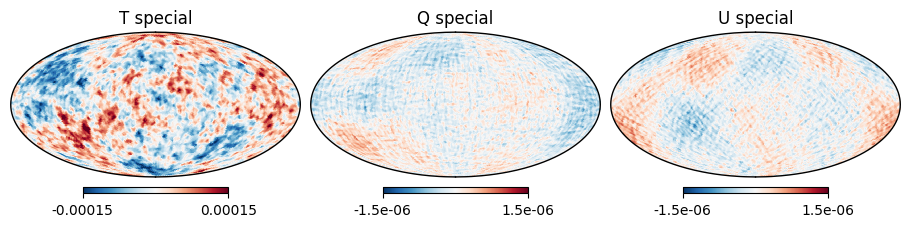

In [6]:
### visualization
plt.figure(figsize=(9, 2), dpi=100)
hp.mollview(special_cmb[0], cmap='RdBu_r', min=-1.5e-4, max=1.5e-4, sub=131, title='T special')
hp.mollview(special_cmb[1], cmap='RdBu_r', min=-1.5e-6, max=1.5e-6, sub=132, title='Q special')
hp.mollview(special_cmb[2], cmap='RdBu_r', min=-1.5e-6, max=1.5e-6, sub=133, title='U special')
hp.graticule(alpha=0.)

In [7]:
### calculate power spectrum
cl_ana = hp.anafast(special_cmb)

# can use other tools, e.g. PolSpice, NaMaster, xpol, xQML, etc. to calculate power spectrum

# Lack of correlation

In [8]:
S12TT_arr = []
S12EE_arr = []
lmin_TT = 2
lmin_EE = 3
lmax_arr = np.arange(5, 20)
for lmax in lmax_arr:
    S12TT_arr.append(lsa.calc_S12_aps(cl_ana[0], lmin=lmin_TT, lmax=lmax, mode='TT'))
    S12EE_arr.append(lsa.calc_S12_aps(cl_ana[0], lmin=lmin_EE, lmax=lmax, mode='EE'))
S12TT_arr = np.array(S12TT_arr)
S12EE_arr = np.array(S12EE_arr)

Text(0.5, 0, '$\\ell$')

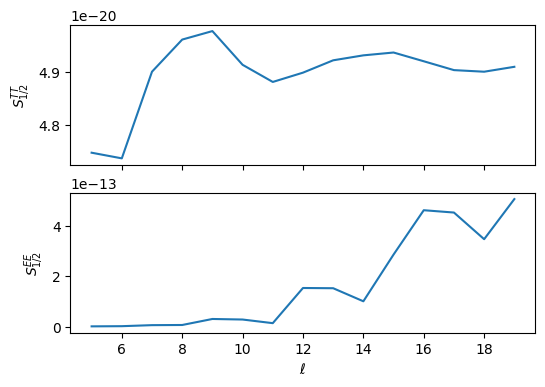

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(6, 4), dpi=100, sharex=True)
ax[0].plot(lmax_arr, S12TT_arr)
ax[0].set_ylabel('$S_{1/2}^{TT}$')
ax[1].plot(lmax_arr, S12EE_arr)
ax[1].set_ylabel('$S_{1/2}^{EE}$')
ax[1].set_xlabel('$\ell$')

# Quadrupole - Octupole Alignment

In [10]:
special_alm = hp.map2alm(special_cmb)

In [11]:
L23TT, ipixTT = lsa.find_max_L23_ipix(special_alm[0], nside=nside)

In [12]:
L23TT

0.7862743817939137

In [13]:
ipixTT

13459

In [14]:
L23, QOvec = lsa.calc_QO(special_alm, nside=nside, pol=True)
QOang = np.squeeze(hp.vec2ang(QOvec, lonlat=True))

In [15]:
L23

array([0.78627438, 0.83525777, 0.56892953])

In [16]:
QOvec

array([0.79860979, 0.40198639, 0.44791667])

In [17]:
QOang

array([26.71875   , 26.61009781])

# Point-parity asymmetry

In [18]:
RTT_arr = []
DEE_arr = []

lmin_RTT = 2
lmin_DEE = 3
lmax_arr = np.arange(5, 20)
for lmax in lmax_arr:
    RTT_arr.append(lsa.calc_R(cl_ana[0], lmin=lmin_RTT, lmax=lmax))
    DEE_arr.append(lsa.calc_D(cl_ana[1], lmin=lmin_DEE, lmax=lmax))
RTT_arr = np.array(RTT_arr)
DEE_arr = np.array(DEE_arr)

Text(0.5, 0, '$\\ell$')

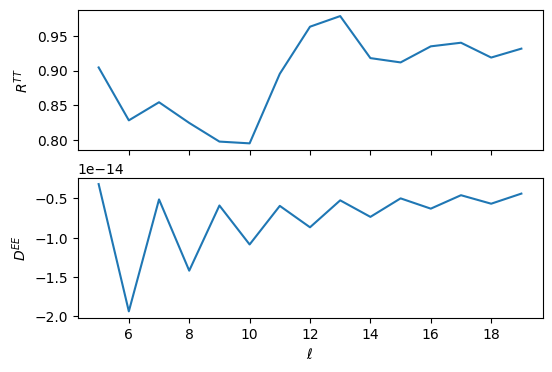

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(6, 4), dpi=100, sharex=True)
ax[0].plot(lmax_arr, RTT_arr)
ax[0].set_ylabel('$R^{TT}$')
ax[1].plot(lmax_arr, DEE_arr)
ax[1].set_ylabel('$D^{EE}$')
ax[1].set_xlabel('$\ell$')

# Hemispherical power asymmetry

In [20]:
### calculate the local variance maps (LVM)
mask = np.zeros(npix, dtype='bool')

special_Emap = lsa.convert_Emap_naive(special_cmb)

lvmT = lsa.calc_lvm(special_cmb[0], mask)[0]
lvmE = lsa.calc_lvm(special_Emap, mask)[0]

/home/shiur/local/large_scale_anomaly/lsa.py:33: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  Emap = hp.alm2map(almE, nside=nside, verbose=False)


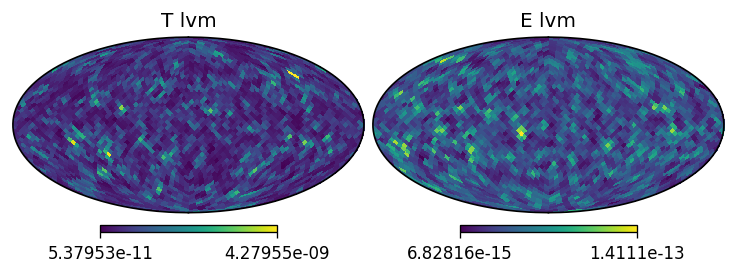

In [21]:
plt.figure(figsize=(6, 2), dpi=120)
hp.mollview(lvmT, sub=121, title='T lvm')
hp.mollview(lvmE, sub=122, title='E lvm')
hp.graticule(alpha=0)

In [22]:
### fit for dipole

bias = np.zeros_like(lvmT) # the noise bias
varlvm = np.ones_like(lvmT) # the variance of different realizations of LVMs

norm = 1e12 # normalization to avoid numerical issue
lvm_dipole_T = 1./norm * lsa.fit_lvm_dipole(lvmT*norm, bias, varlvm)

norm = 1e15 # normalization to avoid numerical issue
lvm_dipole_E = 1./norm * lsa.fit_lvm_dipole(lvmE*norm, bias, varlvm)



In [23]:
# monopole, dip_x, dip_y, dip_z
lvm_dipole_T

array([ 7.64971614e-10, -2.18690499e-13,  1.59903491e-11, -1.89452728e-11])

In [24]:
# monopole, dip_x, dip_y, dip_z
lvm_dipole_E

array([ 4.20688850e-14, -3.07642574e-15,  1.10436483e-15, -1.06872399e-16])